<a href="https://colab.research.google.com/github/saayanbiswas/Autonomous-Car/blob/main/Python%20Notebooks/Enhanced_Traffic_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import random
import pickle
import pandas as pd

In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data= pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data=pickle.load(f)

print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


<class 'dict'>


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0]==y_train.shape[0]),"n(img) != n(labels)"
assert(X_val.shape[0]==y_val.shape[0]),"n(img) != n(labels)"
assert(X_test.shape[0]==y_test.shape[0]),"n(img) != n(labels)"
assert(X_train.shape[1:]==(32,32,3)), "dim(img) != 32 x 32 x 3"

In [ ]:
data=pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

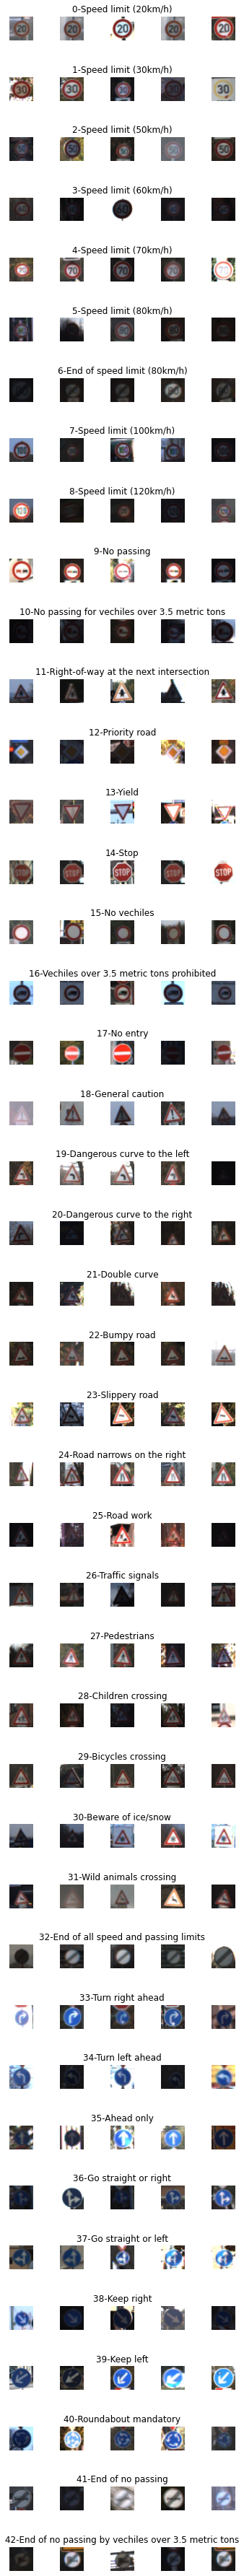

In [ ]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    #(index, Series)
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+ row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

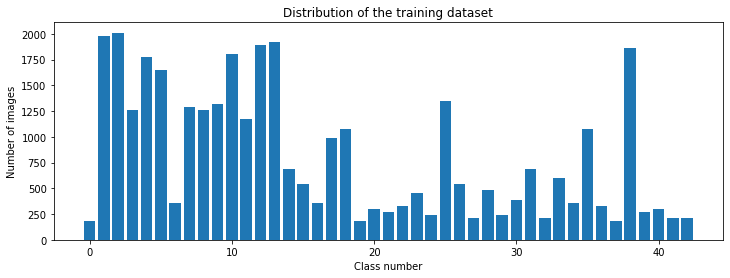

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


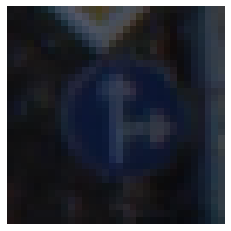

In [ ]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(-0.5, 31.5, 31.5, -0.5)

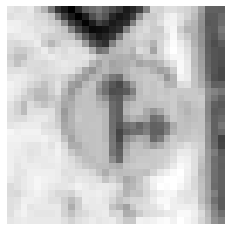

In [ ]:
def grayscale(img):
  img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img=cv2.bitwise_not(img)
  return img

img=grayscale(X_train[1000])

plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


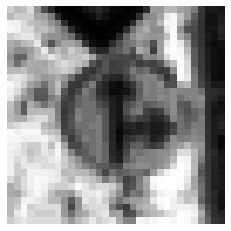

In [ ]:
def equalize(img):
  #histogram equalization can only be doe on grayscale
  img=cv2.equalizeHist(img)
  return img

img=equalize(img)

plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #normalizing img pixels
  img=img/255
  return(img)

#preprocessed datasets after grayscaling and tone mapping
X_train=np.array(list(map(preprocessing, X_train)))
X_val=np.array(list(map(preprocessing, X_val)))
X_test=np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


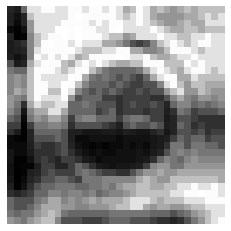

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test= X_test.reshape(12630, 32, 32, 1)
X_val= X_val.reshape(4410, 32, 32, 1)

In [ ]:
#transforming different operations on images to get more augmented images
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range =0.1,
                   height_shift_range =0.1,
                   zoom_range =0.2,
                   shear_range =0.1,
                   rotation_range =10)

datagen.fit(X_train)

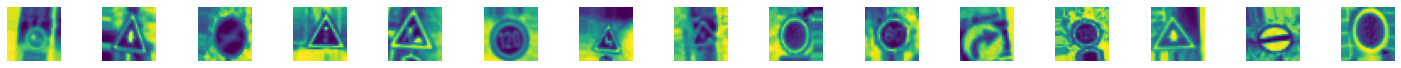

In [ ]:
batches= datagen.flow(X_train, y_train, batch_size=20)

X_batch, y_batch = next(batches)
fig, axs= plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(60, (5, 5), input_shape=(32,32,1), activation='relu'))
  model.add(MaxPooling2D(pool_size= (2,2)))

  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Flatten())
  #model.add(Dropout(0.5))
  #Fully connected layer
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  #output layer
  model.add(Dense(num_classes, activation='softmax'))
  #Compile model
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model= modified_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
h=model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=X_train.shape[0]/50, epochs=15, validation_data=(X_val, y_val), shuffle=1)

Epoch 1/15
  3/695 [..............................] - ETA: 19s - loss: 0.0583 - accuracy: 0.9733

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


695/695 [==============================] - 21s 31ms/step - loss: 0.0929 - accuracy: 0.9725 - val_loss: 0.0262 - val_accuracy: 0.9909
Epoch 2/15
695/695 [==============================] - 22s 31ms/step - loss: 0.0800 - accuracy: 0.9755 - val_loss: 0.0333 - val_accuracy: 0.9916
Epoch 3/15
695/695 [==============================] - 22s 31ms/step - loss: 0.0795 - accuracy: 0.9762 - val_loss: 0.0211 - val_accuracy: 0.9946
Epoch 4/15
695/695 [==============================] - 21s 30ms/step - loss: 0.0676 - accuracy: 0.9793 - val_loss: 0.0271 - val_accuracy: 0.9916
Epoch 5/15
695/695 [==============================] - 22s 31ms/step - loss: 0.0660 - accuracy: 0.9807 - val_loss: 0.0240 - val_accuracy: 0.9939
Epoch 6/15
695/695 [==============================] - 22s 31ms/step - loss: 0.0648 - accuracy: 0.9802 - val_loss: 0.0272 - val_accuracy: 0.9937
Epoch 7/15
695/695 [==============================] - 21s 30ms/step - loss: 0.0652 - accuracy: 0.9805 - val_loss: 0.0252 - val_accuracy: 0.9941
Epo

Text(0.5, 0, 'epoch')

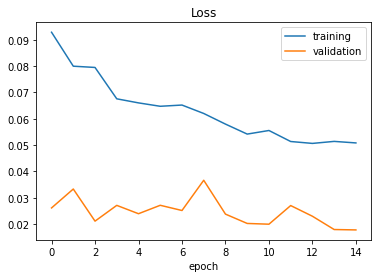

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

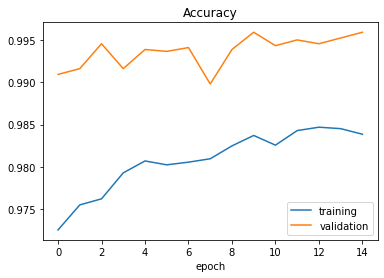

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

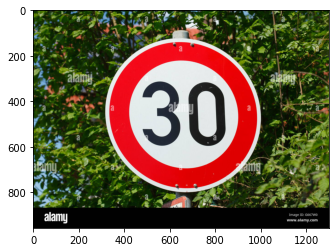

In [ ]:
#fetch image
 
import requests
from PIL import Image
#url of image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


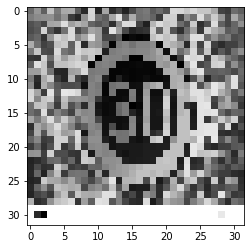

In [ ]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
prediction=np.argmax(model.predict(img), axis=1)
#Test image
print("predicted sign: "+ str(prediction))

predicted sign: [1]


(32, 32)
predicted sign: [40]


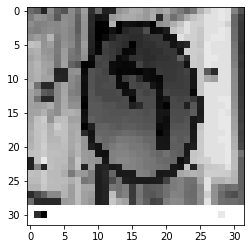

In [ ]:
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
prediction=np.argmax(model.predict(img), axis=1)
#Test image
print("predicted sign: "+ str(prediction))


(32, 32)
predicted sign: [23]


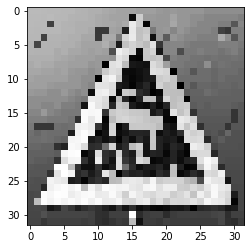

In [ ]:
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
prediction=np.argmax(model.predict(img), axis=1)
#Test image
print("predicted sign: "+ str(prediction))

(32, 32)
predicted sign: [13]


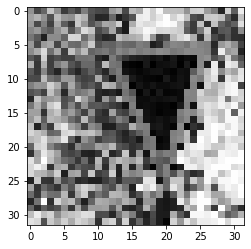

In [ ]:
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
prediction=np.argmax(model.predict(img), axis=1)
#Test image
print("predicted sign: "+ str(prediction))

(32, 32)
predicted sign: [29]


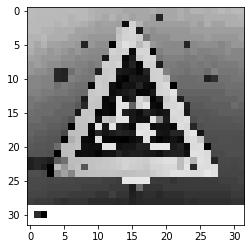

In [ ]:
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
prediction=np.argmax(model.predict(img), axis=1)
#Test image
print("predicted sign: "+ str(prediction))